In [83]:
from aocd import get_data
import cv2
import numpy as np
from collections import Counter, defaultdict
from queue import PriorityQueue
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Optional
import sys
import re
import math
import json
from copy import deepcopy
from functools import lru_cache

def get_input(day):
    return get_data(day=day, year=2021).splitlines()

def read_array(lines, delimeter=',', dtype=int):
    return np.array([dtype(x) for x in lines[0].split(delimeter)])

def read_matrix(lines, delimeter=' ', dtype=int):
    return np.array([[dtype(x) for x in (line.split(delimeter) if delimeter else list(line))] for line in lines], dtype=dtype)

# Day 1

In [94]:
numbers = [int(x) for x in get_input(day=1)]
print(sum(a < b for a, b in list(zip(numbers, numbers[1:]))))
windows = [sum(x) for x in zip(numbers, numbers[1:], numbers[2:])]
print(sum(a < b for a, b in list(zip(windows, windows[1:]))))

1154
1127


# Day 2

In [16]:
directions = get_input(day=2)
depth = 0
aiming_depth = 0
forward = 0
aim = 0

for direction in directions:
    command, value = direction.split(' ')
    value = int(value)
    if command == 'forward':
        forward += value
        aiming_depth += aim * value
    elif command == 'down':
        depth += value
        aim += value
    else:
        depth -= value
        aim -= value
print(depth * forward)
print(aiming_depth * forward)

1507611
1880593125


# Day 3

In [18]:
report = get_input(day=3)
def get_bit(bits, main_char='1'):
    count = Counter(bits)
    if count['1']  == count['0']:
        return main_char
    other_char = str((int(main_char) + 1) % 2)
    return main_char if count['1'] > count['0'] else other_char

bit_lists = list(zip(*report))
gamma = int(''.join(get_bit(bits, '1') for bits in bit_lists), 2)
epsilon = int(''.join(get_bit(bits, '0') for bits in bit_lists), 2)
print(gamma * epsilon)

def get_rating(report, main_char):
    index = 0
    while len(report) > 1:
        comparator = get_bit(list(zip(*report))[index], main_char)
        report = [x for x in report if x[index] == comparator]
        index += 1
    return report[0]

oxygen = int(get_rating(report, main_char='1'), 2)
co2 = int(get_rating(report, main_char='0'), 2)
print(oxygen * co2)

3633500
4550283


# Day 4

In [19]:
BOARD_SIZE = 5
    
class Board():
    def __init__(self, numbers):
        self.numbers = np.array(numbers)
        self.marked = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=bool)
    
    def is_winning(self):
        has_winning_row = np.any(np.all(self.marked, axis=0))
        has_winning_column = np.any(np.all(self.marked, axis=1))
        return has_winning_column | has_winning_row
    
    def mark(self, number):
        self.marked = np.where(self.numbers == number, True, self.marked)
        
    def unmarked(self):
        return self.numbers[~self.marked]

bingo_input = get_input(day=4)
called_numbers = list(map(int, bingo_input[0].split(',')))
boards = []

for i in range(2, len(bingo_input), BOARD_SIZE + 1):
    board_numbers = [list(map(int, row.split())) for row in bingo_input[i:i + BOARD_SIZE]]
    boards.append(Board(board_numbers))
    
            
def solution(boards, called_numbers):
    solution_1 = None
    last_board = None
    for number in called_numbers:
        for board in boards:
            board.mark(number)
            if solution_1 is None and board.is_winning():
                solution_1 = np.sum(board.unmarked() * number)
        boards = [board for board in boards if not board.is_winning()]
        if len(boards) == 1:
            last_board = boards[0]
        if len(boards) == 0:
            return solution_1, np.sum(last_board.unmarked() * number)

print(solution(boards, called_numbers))

(51034, 5434)


# Day 5

In [23]:
def read_lines(line):
    return [tuple(map(int, x.split(','))) for x in line.split(' -> ')]
lines = [read_lines(x) for x in get_input(day=5)]

def calculate_score(lines, count_diagonals=False):
    matrix = np.zeros((1000, 1000), dtype=int)

    for a, b in lines:
        y_distance, x_distance = b[0] - a[0], b[1] - a[1]
        y_sign, x_sign = np.sign(y_distance or 1), np.sign(x_distance or 1)
        if not count_diagonals and abs(y_distance) == abs(x_distance):
            continue
        ys = np.arange(a[0], b[0] + y_sign, y_sign)
        xs = np.arange(a[1], b[1] + x_sign, x_sign)
        matrix[ys, xs] += 1

    return np.sum(matrix >= 2)

print(calculate_score(lines, count_diagonals=False))
print(calculate_score(lines, count_diagonals=True))

5280
16716


# Day 6

In [21]:
fishes = list(map(int, get_input(day=6)[0].split(',')))
future_fishes = []
DAYS_LEFT = 256

def get_future_fishes(day, future_fishes):
    return 1 if day <= 0 else future_fishes[day]

for day in range(DAYS_LEFT):
    future_fishes.append(get_future_fishes(day - 9, future_fishes) +
                         get_future_fishes(day - 7, future_fishes))

def get_fishes(days):
    return sum(future_fishes[days - fish] for fish in fishes)

print(get_fishes(80))
print(get_fishes(256))

351188
1595779846729


# Day 7

In [40]:
numbers = np.array(read_array(get_input(day=7)))
possibles = np.arange(np.max(numbers) + 1)
grid = np.abs(numbers[:, None] - possibles[None, :])
print(np.min(np.sum(grid, axis=0)))
grid *= (grid + 1)
print(np.min(np.sum(grid // 2, axis=0)))

336721
91638945


# Day 8

In [35]:
from itertools import permutations

lines = get_input(day=8)
digit_letters = {
    ('a', 'b', 'c', 'e', 'f', 'g'): 0,
    ('c', 'f'): 1,
    ('a', 'c', 'd', 'e', 'g'): 2,
    ('a', 'c', 'd', 'f', 'g'): 3,
    ('b', 'c', 'd', 'f'): 4,
    ('a', 'b', 'd', 'f', 'g'): 5,
    ('a', 'b', 'd', 'e', 'f', 'g'): 6,
    ('a', 'c', 'f'): 7,
    ('a', 'b', 'c', 'd', 'e', 'f', 'g'): 8,
    ('a', 'b', 'c', 'd', 'f', 'g'): 9,
}
ALL_LETTERS = ['a', 'b', 'c', 'e', 'd', 'f', 'g']

def word_to_digit(word, mapping):
    chars = {mapping[letter] for letter in word}
    return digit_letters[tuple(sorted(chars))]

def solve_line(line):
    words, output_words = line.split(' |')
    words = (words + output_words).split(' ')
    
    for variant in permutations(ALL_LETTERS):
        mapping = {
            letter: variant[i] for i, letter in enumerate(ALL_LETTERS)
        }
        try:
            mapped = [word_to_digit(word, mapping) for word in words]
        except Exception as exc:
            continue
        else:
            return mapped[-4:]

outputs = [solve_line(line) for line in lines]
counter = Counter(digit for output in outputs for digit in output)
print(sum(counter[x] for x in [1, 4, 7, 8]))
output_numbers = [int(''.join([str(x) for x in output])) for output in outputs]
print(sum(output_numbers))

288
940724


# Day 9

In [43]:
matrix = read_matrix(get_input(day=9), delimeter='')
matrix = np.pad(matrix, ((1, 1), (1, 1)), constant_values=(9, ))

DIRECTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
print(sum(
    matrix[i][j] + 1
    for i in range(1, matrix.shape[0] - 1)
    for j in range(1, matrix.shape[1] - 1)
    if all([matrix[i + dx, j + dy] > matrix[i][j] for (dx, dy) in DIRECTIONS])
))
image = np.where(matrix == 9, 0, 255).astype(np.byte)
(_, _, stats, _) = cv2.connectedComponentsWithStats(image, connectivity=4)
areas = list(sorted(stat[cv2.CC_STAT_AREA] for stat in stats[1:]))
print(np.prod(areas[-3:]))

526
1123524


# Day 10

In [45]:
lines = get_input(day=10)
matching_brackets = {
    '{': '}',
    '[': ']',
    '(': ')',
    '<': '>',
}
brackets_score = {
    '}': 1197,
    ']': 57,
    ')': 3,
    '>': 25137,
}
closing_score = {
    '}': 3,
    ']': 2,
    ')': 1,
    '>': 4,
}

def check_syntax(line):
    stack = []
    incomplete_score = 0
    for char in line:
        if char in matching_brackets:
            stack.append(char)
        elif matching_brackets[stack[-1]] == char:
            stack.pop()
        else:
            incomplete_score = brackets_score[char]
            break
    complete_score = 0
    if incomplete_score == 0:
        for char in stack[::-1]:
            complete_score = complete_score * 5 + closing_score[matching_brackets[char]]
        
    return incomplete_score, complete_score

scores = [check_syntax(line) for line in lines]
print(sum(x[0] for x in scores))
scores = list(sorted(x[1] for x in scores if x[1] > 0))
print(scores[len(scores) // 2])

339477
3049320156


# Day 11

In [46]:
matrix = read_matrix(get_input(day=11), delimeter='')
TARGET_STEP = 100

total_flashing = 0
step = 1
are_synced = False
while step < TARGET_STEP or not are_synced:
    matrix += 1
    visited = np.zeros_like(matrix, dtype=bool)
    while True:
        flashing = (matrix > 9) & (~visited)
        flashing_count = np.sum(flashing)
        if flashing_count == 0:
            break
        total_flashing += flashing_count
        visited |= flashing
        
        matrix += cv2.filter2D(flashing.astype(np.uint8), -1, np.ones((3, 3)), borderType=cv2.BORDER_CONSTANT)
    matrix[matrix > 9] = 0
    if step == TARGET_STEP:
        print('total', total_flashing)
    if np.sum(matrix) == 0:
        are_synced = True
        print('sync', step)
    step += 1

total 1793
sync 247


# Day 12

In [49]:
lines = get_input(day=12)
connectivity = defaultdict(list)
for line in lines:
    a, b = line.split('-')
    connectivity[a].append(b)
    connectivity[b].append(a)

def dfs(current, visited, can_repeat):
    if current == 'end':
        yield 1
        return
    for neighbor in connectivity[current]:
        if neighbor == 'start':
            continue
        is_repeated = neighbor.islower() and neighbor in visited
        if not can_repeat and is_repeated:
            continue
        yield from dfs(neighbor, visited | {neighbor}, can_repeat & (not is_repeated))
        
print(sum(dfs('start', {'start'}, False)))
print(sum(dfs('start', {'start'}, True)))

4304
118242


# Day 13

807


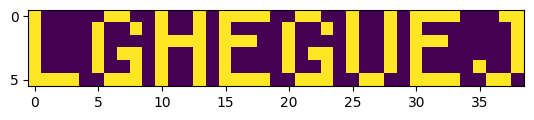

In [52]:
lines = get_input(day=13)

points = set()
folds = []
for line in lines:
    if '=' in line:
        direction, mid = line.split('=')
        mid = int(mid)
        fold = (mid * 2, 0) if direction[-1] == 'x' else (0, mid * 2)
        folds.append(fold)
    elif ',' in line:
        points.add(tuple(map(int, line.split(','))))
        
def fold_point(point, fold):
    if point[0] < fold[0] / 2 or point[1] < fold[1] / 2:
        return point
    return abs(fold[0] - point[0]), abs(fold[1] - point[1]) 

for i, fold in enumerate(folds):
    points = {fold_point(point, fold) for point in points}
    if i == 0:
        print(len(points))

image = np.zeros(
    (max(point[1] for point in points) + 1,
     max(point[0] for point in points) + 1)
)

for point in points:
    image[point[1], point[0]] = 255
plt.imshow(image)
plt.show()

# Day 14

In [54]:
lines = get_input(day=14)
polymer = lines[0]
rules = {}
precomputed = {}

for rule in lines[2:]:
    chain_from, chain_creates = rule.split(' -> ')
    rules[chain_from] = chain_creates
    precomputed[chain_from] = Counter(chain_from)

TARGET_STEP_1 = 10
TARGET_STEP_2 = 40
for step in range(0, max(TARGET_STEP_1, TARGET_STEP_2)):
    new_precomputed = {}
    for base in rules.keys():
        created = rules[base]
        new_precomputed[base] = (
            precomputed[base[0] + created] +
            precomputed[created + base[1]] -
            Counter([created])
        )
    precomputed = new_precomputed
    if step + 1 in [TARGET_STEP_1, TARGET_STEP_2]:
        final_counter = Counter()
        for x, y in zip(polymer, polymer[1:]):
            final_counter += precomputed[x + y]
        final_counter -= Counter(polymer[1:-1])
        most_common = final_counter.most_common()
        print(most_common[0][1] - most_common[-1][1])

2549
2516901104210


# Day 15

In [64]:
matrix = read_matrix(get_input(day=15), delimeter='')
DIRECTIONS = [(1, 0), (-1, 0), (0, 1), (0, -1)]

@dataclass(order=True)
class State:
    cost: int
    pos: Tuple[int, int]

def get_score(matrix):
    matrix = np.pad(matrix, ((1, 1), (1, 1)), constant_values=(100000, ))
    queue = PriorityQueue()
    queue.put(State(pos=(1, 1), cost=0))
    min_reached = defaultdict(lambda: sys.maxsize)
    
    while not queue.empty():
        current = queue.get()
        if current.pos == (matrix.shape[0] - 2, matrix.shape[1] - 2):            
            return current.cost
        
        if current.cost > min_reached[current.pos]:
            continue
        
        for dx, dy in DIRECTIONS:
            nx, ny = current.pos[0] + dx, current.pos[1] + dy
            current_cost = current.cost + matrix[nx, ny]
            if current_cost < min_reached[(nx, ny)]:
                queue.put(State(pos=(nx, ny), cost=current_cost))
                min_reached[(nx, ny)] = current_cost
    return best_found

print(get_score(matrix))
row = np.concatenate([matrix + i for i in range(5)], axis=0)
new_matrix = np.concatenate([row + i for i in range(5)], axis=1)
new_matrix = np.mod(new_matrix - 1, 9) + 1
print(get_score(new_matrix))

487
2821


# Day 16

In [65]:
hex_representation = get_input(day=16)[0]
binary_representation = bin(int(hex_representation, 16))[2:]
missing_padding = 4 - len(binary_representation) % 4
binary_representation = '0' * (missing_padding if 0 < missing_padding < 4 else 0) + binary_representation

class Packet:
    def __init__(self, version):
        self.version = version
    
    def get_versions(self):
        return [self.version]
        
class LiteralValue(Packet):
    def __init__(self, version, value):
        super().__init__(version)
        self.value = value
        
    @classmethod
    def parse_packet(cls, version, binary):
        number = ''
        for i in range(0, len(binary), 5):
            number += binary[i + 1:i + 5]
            if binary[i] == '0':
                break
        return LiteralValue(version, int(number, 2)), i + 5
    
    def get_value(self):
        return self.value
        
class Operator(Packet):
    def __init__(self, version, operator_type, children):
        super().__init__(version)
        self.operator_type = operator_type
        self.children = children
        
    @classmethod
    def parse_packet(cls, version, operator_type, binary):
        length_type, contents = binary[0], binary[1:]
        children = []
        total_bits = 0
            
        if length_type == '0':
            length, contents = contents[:15], contents[15:]
            total_bits += 16
            
            bits_remaining = int(length, 2)
            packets_remaining = -1
        else:
            length, contents = contents[:11], contents[11:]
            total_bits += 12
            
            bits_remaining = -1
            packets_remaining = int(length, 2)
            
        while (bits_remaining != 0) and (packets_remaining != 0):
            packet, bits_used = read_packet(contents)
            children.append(packet)
            contents = contents[bits_used:]
            if bits_remaining > 0:
                bits_remaining -= bits_used
            else:
                packets_remaining -= 1
            total_bits += bits_used
        return Operator(version, operator_type, children), total_bits
    
    def get_versions(self):
        return [self.version] + [version for child in self.children for version in child.get_versions()]
    
    def get_value(self):
        values = [x.get_value() for x in self.children]
        if self.operator_type == 0:
            return sum(values)
        elif self.operator_type == 1:
            return np.product(values)
        elif self.operator_type == 2:
            return min(values)
        elif self.operator_type == 3:
            return max(values)
        elif self.operator_type == 5:
            return int(values[0] > values[1])
        elif self.operator_type == 6:
            return int(values[0] < values[1])
        elif self.operator_type == 7:
            return int(values[0] == values[1])
            
        
    
def read_packet(binary):
    header, contents = binary[:6], binary[6:]
    version = int(header[:3], 2)
    packet_type = int(header[3:], 2)
    
    if packet_type == 4:
        packet, bits_used = LiteralValue.parse_packet(version, contents)
    else:
        packet, bits_used = Operator.parse_packet(version, packet_type, contents)
    
    return packet, bits_used + len(header)

packet = read_packet(binary_representation)[0]
print(sum(packet.get_versions()))
print(packet.get_value())

913
1510977819698


# Day 17

In [72]:
lines = get_input(day=17)
match = re.match(r'target area: x=(-?\d+)..(-?\d+), y=(-?\d+)..(-?\d+)', lines[0])
min_x, max_x, min_y, max_y = map(int, match.groups())

def calculate_x(start, steps):
    steps = min(steps - 1, abs(start))
    end = start + (steps if start < 0 else -steps)
    start, end = min(start, end), max(start, end)
    return (end - start + 1) * (start + end) // 2

def calculate_y(start, steps):
    return steps * (2 * start - steps + 1) // 2

start_x = math.ceil(np.roots([0.5, 0.5, -min_x])[1])
end_x = max_x

def get_possible_step(start):
    roots = np.concatenate(
        [np.roots([-1, 2 * start + 1, -2 * max_y]),
         np.roots([-1, 2 * start + 1, -2 * min_y])]
    )
    roots = [int(x) for x in roots if int(x) > 0]
    if len(roots) == 0:
        return []
    return range(max(min(roots) - 1, 1), max(roots) + 1)

possibles = [
    (x, y, step)
    for x in range(start_x - 1, end_x + 1)
    for y in range(-1000, 1000)
    for step in get_possible_step(y)
    if min_y <= calculate_y(y, step) <= max_y and min_x <= calculate_x(x, step) <= max_x
]
print(max(
    calculate_y(y, step)
    for x, y, max_step in possibles
    for step in range(1, max_step)
))
print(len({(x, y) for x, y, _ in possibles}))

35511
3282


# Day 18

In [79]:
lines = get_input(day=18)

@dataclass(eq=False)
class Node:
    parent: Optional['Node'] = None
    left: Optional['Node'] = None
    right: Optional['Node'] = None
    value: Optional[int] = None
        
    def __repr__(self):
        if self.value is not None:
            return str(self.value)
        return f'[{self.left},{self.right}]'
        
    @staticmethod
    def from_array(json_value, parent=None) -> 'Node':
        if isinstance(json_value, int):
            return Node(value=json_value, parent=parent)
        new_node = Node(parent=parent)
        new_node.left = Node.from_array(json_value[0], parent=new_node)
        new_node.right = Node.from_array(json_value[1], parent=new_node)
        return new_node
    
    @staticmethod
    def add(a: 'Node', b: 'Node') -> 'Node':
        a, b = deepcopy(a), deepcopy(b)
        new_node = Node(left=a, right=b)
        a.parent = new_node
        b.parent = new_node
        return new_node
    
    def traverse(self, depth, matcher):
        if matcher(self, depth):
            return self
        return (
            (self.left and self.left.traverse(depth + 1, matcher)) or
            (self.right and self.right.traverse(depth + 1, matcher))
        )
    
    def take(self, left):
        return self.left if left else self.right
    
    def find_closest(self, left=True):
        current = self.parent
        prev = self
        while current is not None and current.take(left) == prev:
            prev = current
            current = prev.parent
        if current is None:
            return current
        current = current.take(left)
        while current.value is None:
            current = current.take(not left)
        return current
    
    def explode(self):
        exploding_node = self.traverse(0, lambda node, depth: depth == 4 and node.value is None)
        if exploding_node is None:
            return False
        closest_left = exploding_node.find_closest(True)
        if closest_left is not None:
            closest_left.value += exploding_node.left.value
        closest_right = exploding_node.find_closest(False)
        if closest_right is not None:
            closest_right.value += exploding_node.right.value
            
        exploding_node.value = 0
        exploding_node.left = None
        exploding_node.right = None
        return True
    
    def split(self):
        splitting_node = self.traverse(0, lambda node, _: node.value is not None and node.value > 9)
        if splitting_node is None:
            return False
        new_node = Node(
            parent=splitting_node.parent,
            left=Node(value=splitting_node.value // 2),
            right=Node(value=splitting_node.value // 2 + splitting_node.value % 2))
        new_node.left.parent = new_node
        new_node.right.parent = new_node
        if splitting_node.parent.left == splitting_node:
            splitting_node.parent.left = new_node
        else:
            splitting_node.parent.right = new_node
        return True
        
    def reduce(self):
        while(True):
            if self.explode():
                continue
            if self.split():
                continue
            break
        return self

    def magnitude(self):
        if self.value is not None:
            return self.value
        return self.left.magnitude() * 3 + self.right.magnitude() * 2
    
current, *nodes = [Node.from_array(json.loads(line)) for line in lines]
for node in nodes:
    current = Node.add(current, node).reduce()

print(current.magnitude())
nodes = [Node.from_array(json.loads(line)) for line in lines]

print(max(
    Node.add(node, other_node).reduce().magnitude()
    for i, node in enumerate(nodes)
    for j, other_node in enumerate(nodes)
    if i != j
))

4132
4685


# Day 19

In [80]:
lines = get_input(day=19)
scanners = []
current_scanner = []
for line in [x for x in lines[1:] if x]:
    if line.startswith('--'):
        scanners.append(np.array(current_scanner))
        current_scanner = []
    else:
        current_scanner.append(tuple(map(int, line.split(','))))
scanners.append(np.array(current_scanner))

FLIPS = np.array([[x, y, z] for x in [-1, 1] for y in [-1, 1] for z in [-1, 1]])
AXIS = np.array(list(permutations(range(3))))

beacons, *scanners_left = scanners
merged_scanners = set()
scanner_coordinates = [(0, 0, 0)]

while len(scanners_left) > len(merged_scanners):
    for scanner_id, scanner in enumerate(scanners_left):
        if scanner_id in merged_scanners:
            continue
        potential_beacons = (np.take(scanner, AXIS, axis=1)[:, None, :] * FLIPS[:, None])
        potential_beacons = np.reshape(potential_beacons, (potential_beacons.shape[0], -1, 3))
        potential_beacons = np.transpose(potential_beacons, (1, 0, 2))
        offsets = beacons - potential_beacons[:, :, None, :]
        together = np.reshape(offsets, (48, -1, 3))
        best_counter = max([
            (i, ) + Counter([tuple(x) for x in together[i, ...].tolist()]).most_common()[0] 
            for i in range(48)
        ], key=lambda x: x[2])
        if best_counter[2] >= 12:
            beacons = np.concatenate([beacons, (potential_beacons[best_counter[0]] + best_counter[1])])
            beacons = np.unique(beacons, axis=0)
            merged_scanners.add(scanner_id)
            scanner_coordinates.append(best_counter[1])
print(len(beacons))

scanner_coordinates = np.array(scanner_coordinates)
diffs = np.abs(scanner_coordinates[:, None] - scanner_coordinates[None, :])
print(max(np.sum(diffs.reshape(-1, 3), axis=1)))

396
11828


# Day 20

In [81]:
lines = get_input(day=20)
decoder = np.array([1 if x == '#' else 0 for x in lines[0]])
matrix = read_matrix([[1 if x == '#' else 0 for x in row] for row in lines[2:]], delimeter='')
kernel = np.reshape([1 << x for x in range(8, -1, -1)], (3, 3)).astype(np.uint16)

def do_step(matrix, step_index):
    border_value = decoder[0] if step_index % 2 else decoder[511]
    matrix = np.pad(matrix, ((2, 2), (2, 2)), constant_values=(border_value, ))
    matrix = cv2.filter2D(matrix.astype(np.uint16), -1, kernel)
    return decoder[matrix[1:-1, 1:-1]]

for i in range(50):
    matrix = do_step(matrix, i)
    if i in {1, 49}:
        print(np.sum(matrix))

5498
16014


# Day 21

In [84]:
positions = [6, 8]
scores = [0, 0]
class PracticeDice:
    def __init__(self):
        self.rolled = 0
        self.current = 1
        
    def roll(self):
        self.rolled +=1
        current = self.current
        self.current = (self.current + 2) % 100 - 1
        return current
    
dice = PracticeDice()
turn = 0
while max(scores) < 1000:
    dice_sum = dice.roll() + dice.roll() + dice.roll()
    positions[turn] = (positions[turn] + dice_sum - 1) % 10 + 1
    scores[turn] += positions[turn]
    turn = 1 - turn
print(min(scores) * dice.rolled)

DICE_SUMS_COUNTS = Counter(a + b + c for a in range(1, 4) for b in range(1, 4) for c in range(1, 4))

@lru_cache(maxsize=10 * 10 * 2 * 30 * 30)
def universe_winners(positions, scores, turn):
    def calc_params(players, scores, turn, dice_sum):
        players, scores = list(players), list(scores)
        players[turn] = (players[turn] + dice_sum - 1) % 10 + 1
        scores[turn] += players[turn]
        return tuple(players), tuple(scores)
    if scores[0] >= 21:
        return [1, 0]
    if scores[1] >= 21:
        return [0, 1]
    
    winners = [0, 0]
    for dice_sum, count in DICE_SUMS_COUNTS.items():
        winner_counts = universe_winners(*calc_params(positions, scores, turn, dice_sum), 1 - turn)
        winners[0] += winner_counts[0] * count
        winners[1] += winner_counts[1] * count
    return winners

print(max(universe_winners((6, 8), (0, 0), 0)))

757770
712381680443927


# Day 25

In [85]:
matrix = read_matrix([
    x.replace('.', '0').replace('>', '1').replace('v', '2')
    for x in get_input(day=25)
], delimeter='', dtype=np.uint8)

right_kernel = np.array([[0, 0, 0], [1, 0, 10], [0, 0, 0]], dtype=np.uint8)
down_kernel = np.array([[0, 1, 0], [0, 0, 0], [0, 10, 0]], dtype=np.uint8)

def do_movement(matrix, kernel, value):
    matrix = np.concatenate([matrix, matrix[:2]], axis=0)
    matrix = np.concatenate([matrix, matrix[:, :2]], axis=1)

    surrounding = cv2.filter2D(matrix, -1, kernel)    
    new_matrix = np.where((matrix == 0) & (np.mod(surrounding, 10) == value), value, matrix)
    new_matrix = np.where((matrix == value) & (surrounding < 10), 0, new_matrix)
    
    new_matrix[:, 0] = new_matrix[:, -2]
    new_matrix[0, :] = new_matrix[-2, :]
    return new_matrix[:-2, :-2]

def do_step(matrix):
    matrix = do_movement(matrix, right_kernel, 1)
    matrix = do_movement(matrix, down_kernel, 2)
    return matrix
    
step = 1
while True:
    new_matrix = do_step(matrix)
    if np.all(new_matrix == matrix):
        print(step)
        break
    matrix = new_matrix
    step += 1

441
